<a href="https://colab.research.google.com/github/ajain3765/CBIR/blob/main/CBIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import save_model
import keras

In [ ]:
class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

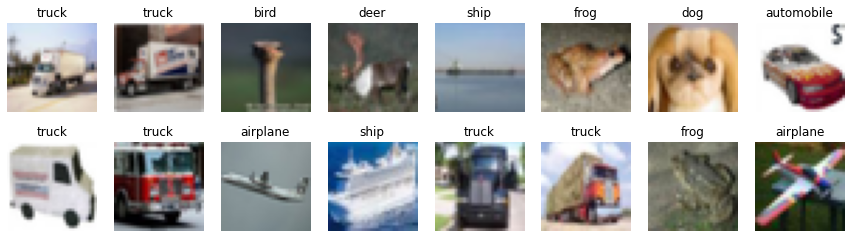

In [ ]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

In [ ]:
IMG_SHAPE = x_train.shape[1:]

# center images
x_train = x_train.astype('float32') / 255.0 - 0.5
x_test = x_test.astype('float32') / 255.0 - 0.5

In [ ]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size)) 
#     encoder.summary()

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder.add(L.Dense(2*2*256))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='sigmoid', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='sigmoid', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='sigmoid', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [ ]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

In [ ]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adam", loss='mse' , metrics=['accuracy'])

In [ ]:
autoencoder.save("autoencoder")
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

INFO:tensorflow:Assets written to: autoencoder/assets


Epoch 1/25
1047/1047 [==============================] - 139s 125ms/step - loss: 0.0318 - accuracy: 0.4395 - val_loss: 0.0186 - val_accuracy: 0.4527
Epoch 2/25
1047/1047 [==============================] - 133s 127ms/step - loss: 0.0171 - accuracy: 0.4606 - val_loss: 0.0160 - val_accuracy: 0.4915
Epoch 3/25
1047/1047 [==============================] - 136s 130ms/step - loss: 0.0138 - accuracy: 0.5884 - val_loss: 0.0131 - val_accuracy: 0.6184
Epoch 4/25
1047/1047 [==============================] - 134s 128ms/step - loss: 0.0130 - accuracy: 0.6154 - val_loss: 0.0129 - val_accuracy: 0.6359
Epoch 5/25
1047/1047 [==============================] - 135s 129ms/step - loss: 0.0128 - accuracy: 0.6206 - val_loss: 0.0127 - val_accuracy: 0.6091
Epoch 6/25
1047/1047 [==============================] - 134s 128ms/step - loss: 0.0127 - accuracy: 0.6245 - val_loss: 0.0126 - val_accuracy: 0.6244
Epoch 7/25
1047/1047 [==============================] - 133s 127ms/step - loss: 0.0126 - accuracy: 0.6281 - val_

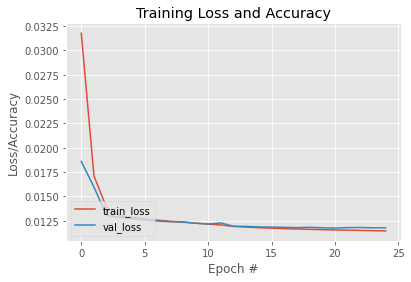

In [ ]:
H = autoencoder.fit(x=x_train, y=x_train, epochs=25,
                validation_split=0.33,
                verbose=1,
                initial_epoch= 0)
N = np.arange(0, 25)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
#plt.plot(N, H.history["val_accuracy"], label="accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
autoencoder.save("CBIR")

INFO:tensorflow:Assets written to: CBIR/assets


In [ ]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

In [ ]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

In [ ]:
reconstruction_mse = autoencoder.evaluate(x_test, x_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)

Convolutional autoencoder MSE: [0.011750166304409504, 0.7024003863334656]


In [ ]:
images = x_train
codes = encoder.predict(images)

In [ ]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
def show_similar(image):   
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

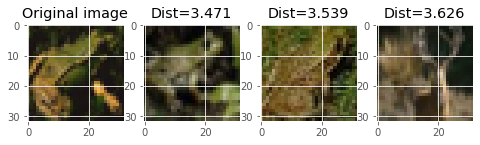

In [ ]:
show_similar(x_test[41])

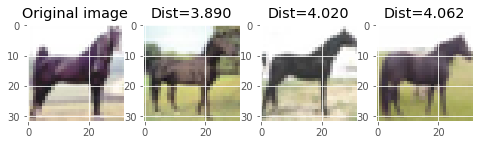

In [ ]:
show_similar(x_test[9975])

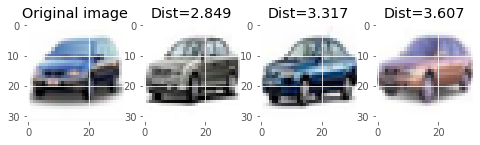

In [ ]:
show_similar(x_test[283])

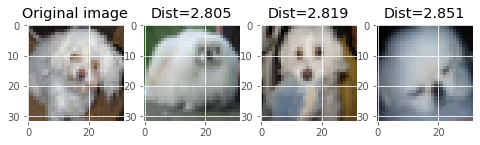

In [ ]:
show_similar(x_test[1000])

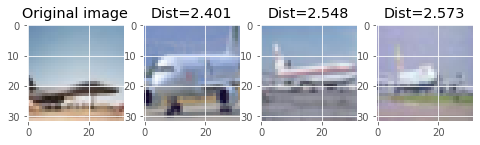

In [ ]:
show_similar(x_test[2993])

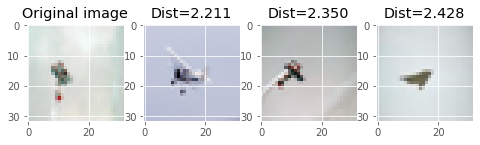

In [ ]:
show_similar(x_test[313])

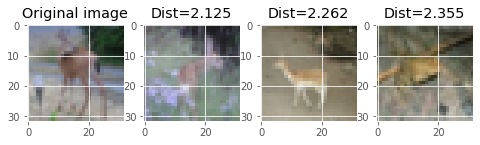

In [ ]:
show_similar(x_test[100])

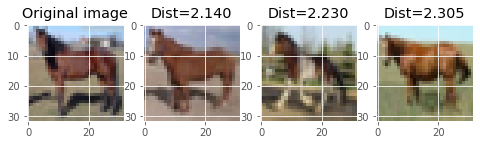

In [ ]:
show_similar(x_test[800])